<a href="https://colab.research.google.com/github/respect5716/deep-learning-paper-implementation/blob/main/02_Vision/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DDPM

## 0. Info

### Paper
* title: Denoising Diffusion Probabilistic Models
* author: Jonathan Ho et al.
* url: https://arxiv.org/abs/2006.11239

### Features
* dataset: FFHQ-64

### Reference
* https://huggingface.co/blog/annotated-diffusion
* https://github.com/labmlai/annotated_deep_learning_paper_implementations/tree/master/labml_nn/diffusion

## 1. Setup

In [ ]:
import os
import math
import einops
import easydict
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.utils import make_grid

from datasets import load_dataset

In [ ]:
cfg = easydict.EasyDict(
    batch_size = 16,
    device = 'cuda:0',
    T = 500,
    num_epochs = 3,
    image_size = 64,
    n_channels = 64,
)

## 2. Data

In [ ]:
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.Resize(cfg.image_size),
    T.ToTensor(),
    T.Lambda(lambda t: (t * 2) - 1)
])


reverse_transform = T.Compose([
    T.Lambda(lambda t: torch.tanh(t)),
    T.Lambda(lambda t: (t + 1.) / 2.),
    T.ToPILImage()
])


class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self.images = glob('/mnt/ffhq-1024/images/*')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        img = Image.open(img).convert('RGB')
        return train_transform(img)

In [ ]:
dataset = Dataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
batch.size()

torch.Size([16, 3, 64, 64])

## 3. Model

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
    
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels, time_mult=4):
        super().__init__()
        self.n_channels = n_channels
        self.time_mult = time_mult
        self.time_channels = self.n_channels * self.time_mult
        
        self.linear1 = nn.Linear(self.n_channels, self.time_channels)
        self.act = Swish()
        self.linear2 = nn.Linear(self.time_channels, self.time_channels)

    def forward(self, t):
        half_dim = self.n_channels // 2
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.linear1(emb)
        emb = self.act(emb)
        emb = self.linear2(emb)
        return emb
    
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, n_groups=32):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x, t):
        h = self.conv1(self.act1(self.norm1(x)))
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.shortcut(x)
    
    
class AttentionBlock(nn.Module):
    def __init__(self, n_channels, n_heads=1, n_groups=32, head_dim=None):
        super().__init__()
        self.n_heads = n_heads
        head_dim = head_dim if head_dim else n_channels
                
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.proj = nn.Linear(n_channels, n_heads * head_dim * 3)
        self.output = nn.Linear(n_heads * head_dim, n_channels)
        self.scale = head_dim ** -0.5

    def forward(self, x, t=None):
        _ = t
        bs, c, h, w = x.shape
        x = einops.rearrange(x, 'b c h w -> b (h w) c')
        qkv = einops.rearrange(self.proj(x), 'b s (nh dim) -> b nh s dim', nh=self.n_heads)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        
        attn = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = attn.softmax(dim=-1)
        res = torch.einsum('bhij,bhjd->bhid', attn, v)
        
        res = einops.rearrange(res, 'b h s d -> b s (h d)')
        res = self.output(res)
        res += x
        
        res = einops.rearrange(res, 'b (h w) d -> b d h w', h=h, w=w)
        return res
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, has_attn):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x
    
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, has_attn):
        super().__init__()
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x

    
class MiddleBlock(nn.Module):
    def __init__(self, n_channels, time_channels):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x, t):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x
    
    
class Upsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x, t):
        return self.conv(x)
    

class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x, t):
        return self.conv(x)

In [ ]:
class Unet(nn.Module):
    def __init__(
        self, 
        image_channels = 3, 
        n_channels = 64,
        ch_mults = (1, 2, 2, 4),
        is_attn = (False, False, True, True),
        n_blocks = 2,
        time_mult = 4
    ):

        super().__init__()
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=3, padding=1)
        self.time_emb = TimeEmbedding(n_channels, time_mult=time_mult)
        n_resolutions = len(ch_mults)

        self.down = nn.ModuleList()
        out_channels = in_channels = n_channels
        for i in range(n_resolutions):
            out_channels = in_channels * ch_mults[i]
            for _ in range(n_blocks):
                self.down.append(DownBlock(in_channels, out_channels, n_channels * time_mult, is_attn[i]))
                in_channels = out_channels
            if i < n_resolutions - 1:
                self.down.append(Downsample(in_channels))


        self.middle = MiddleBlock(out_channels, n_channels * time_mult)

        self.up = nn.ModuleList()
        in_channels = out_channels
        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            for _ in range(n_blocks):
                self.up.append(UpBlock(in_channels, out_channels, n_channels * time_mult, is_attn[i]))
            out_channels = in_channels // ch_mults[i]
            self.up.append(UpBlock(in_channels, out_channels, n_channels * time_mult, is_attn[i]))
            in_channels = out_channels
            if i > 0:
                self.up.append(Upsample(in_channels))


        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

        
    def forward(self, x, t):
        t = self.time_emb(t)
        x = self.image_proj(x)

        h = [x]
        for m in self.down:
            x = m(x, t)
            h.append(x)

        x = self.middle(x, t)

        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x, t)

        return self.final(self.act(self.norm(x)))

## 4. Train

In [ ]:
def extract_1d(tensor, index, expand_dim=3):
    value = torch.gather(tensor, 0, index)
    
    pattern = 'b -> b'
    for _ in range(expand_dim):
        pattern += ' 1'
    return einops.repeat(value, pattern)


def diffusion_process(x_0, t, noise):
    mean = torch.sqrt(alphas_bar)
    var = torch.sqrt(1. - alphas_bar)
    mean_t = extract_1d(mean, t)
    var_t = extract_1d(var, t)
    return mean_t * x_0 + var_t * noise

def reverse_process(model, x_t, t):
    betas_t = extract_1d(betas, t)
    alphas_t = extract_1d(alphas, t)
    alphas_bar_t = extract_1d(alphas_bar, t)
    
    with torch.no_grad():
        epsilon_t = model(x_t, t)
    mus_tilde_t = 1 / torch.sqrt(alphas_t) * (x_t - betas_t / torch.sqrt(1. - alphas_bar_t) * epsilon_t)
    betas_tilde_t = extract_1d(betas_tilde, t)
    
    noise = torch.randn_like(x_t)
    return mus_tilde_t + torch.sqrt(betas_tilde_t) * noise


def linear_beta_schedule(T):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, T)


def generate(model, T, x_t=None, shape=None, track=False):
    assert x_t is not None or shape is not None
    device = next(model.parameters()).device
    if x_t is None:
        x_t = torch.randn(*shape, device=device)
    
    history = []
    bs = x_t.size(0)
    for t in reversed(range(T)):
        t = torch.full((bs,), t, device=device, dtype=torch.long)
        x_t = reverse_process(model, x_t, t)
        
        if track:
            history.append(x_t.cpu())
    
    return x_t, history

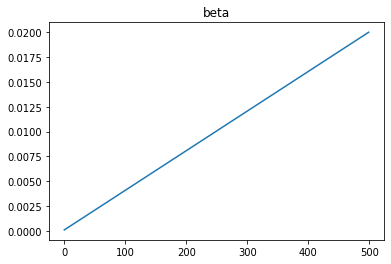

In [ ]:
betas = linear_beta_schedule(cfg.T).to(cfg.device)

plt.title('beta')
plt.plot(einops.asnumpy(betas))
plt.show()

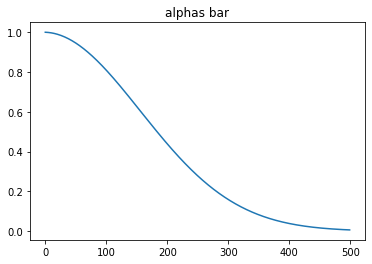

In [ ]:
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, axis=0)
alphas_bar_0 = torch.tensor([1.], device=alphas.device)
alphas_bar_prev = torch.concat([alphas_bar_0, alphas_bar[:-1]])
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

plt.title('alphas bar')
plt.plot(einops.asnumpy(alphas_bar))
plt.show()

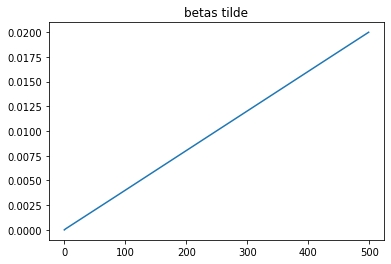

In [ ]:
betas_tilde = betas * (1. - alphas_bar_prev) / (1. - alphas_bar)
plt.title('betas tilde')
plt.plot(einops.asnumpy(betas_tilde))
plt.show()

In [ ]:
model = Unet(
    n_channels = cfg.n_channels
)
_ = model.to(cfg.device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = F.l1_loss

In [ ]:
os.makedirs('results', exist_ok=True)
for ep in range(cfg.num_epochs):
    pbar = tqdm(dataloader)
    for st, batch in enumerate(pbar):
        bs = batch.size(0)
        batch = batch.to(cfg.device)

        t = torch.randint(0, cfg.T, (bs,), device=cfg.device).long()
        noise = torch.randn_like(batch)
        x_noised = diffusion_process(x_0=batch, t=t, noise=noise)
        noise_pred = model(x_noised, t)
        loss = criterion(noise, noise_pred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_postfix({'loss': loss.item()})
        if st % 1000 == 0:
            gen, _ = generate(model, cfg.T, shape=(4, 3, cfg.image_size, cfg.image_size))
            gen = reverse_transform(make_grid(gen)).resize((128*4, 128))
            gen.save(f'results/{ep:02d}-{st:04d}.png')
            torch.save(model.state_dict(), 'ckpt.pt')

torch.save(model.state_dict(), 'ckpt.pt')

  0%|          | 0/4375 [00:00<?, ?it/s]

  0%|          | 0/4375 [00:00<?, ?it/s]

  0%|          | 0/4375 [00:00<?, ?it/s]

## 5. Test

In [ ]:
model = Unet(
    n_channels = cfg.n_channels
)

_ = model.to(cfg.device).eval()
model.load_state_dict(torch.load('ckpt.pt'))

<All keys matched successfully>

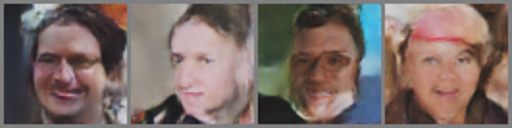

In [ ]:
gen, history = generate(model, cfg.T, shape=(4, 3, cfg.image_size, cfg.image_size), track=True)
gen = reverse_transform(make_grid(gen)).resize((128*4, 128))
gen

In [ ]:
hist_idx = 1
hist = [history[i][hist_idx] for i in range(0, len(history), 10)]
hist = torch.stack(hist, dim=0)

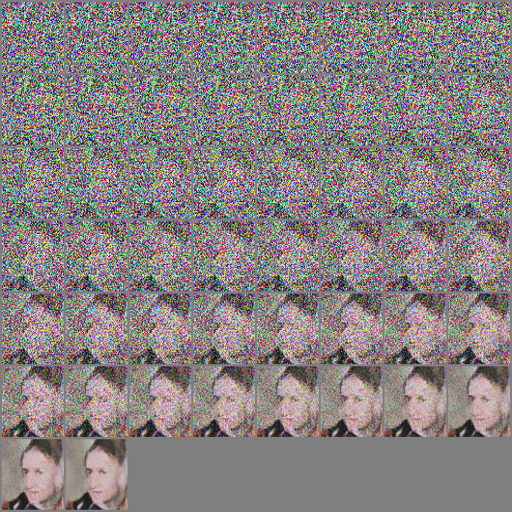

In [ ]:
reverse_transform(make_grid(hist)).resize((512, 512))